### Problem-2
Here we combine what you've learned about ColumnarStructure with skills from previous tutorials. We use ColumnarStructure to calculate the average number of water molecules per amino acid residue (waterRatio) and the average b-factor (temperature factor). We capture the information in a dataset and then plot the waterRatio against the resolution to see if there is a trend in the data.

In [14]:
from pyspark.sql import Row, SparkSession
from mmtfPyspark.filters import ContainsLProteinChain, ExperimentalMethods
from mmtfPyspark.io import mmtfReader
from mmtfPyspark.ml import pythonRDDToDataset
from mmtfPyspark.utils import ColumnarStructure
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

#### Configure Spark

In [15]:
spark = SparkSession.builder.master("local[4]").appName("Solution-2").getOrCreate()
sc = spark.sparkContext

### Read PDB structures

In [16]:
path = "../resources/mmtf_full_sample"
pdb = mmtfReader.read_sequence_file(path, sc).cache()

### TODO-1: filter structures: exclusively protein structures

In [18]:
pdb = pdb.filter(ContainsLProteinChain(exclusive=True))

### TODO-2: filter structures: only structures determined by ExperimentalMethods.X_RAY_DIFFRACTION

In [19]:
pdb = pdb.filter(ExperimentalMethods(ExperimentalMethods.X_RAY_DIFFRACTION))

### Keep only structures with one model

In [20]:
pdb = pdb.filter(lambda t: t[1].num_models ==1)

In [27]:
def calcProperties(s):
    # s[0] pdb id
    # s[1] mmtf structure record
    arrays = ColumnarStructure(s[1], firstModelOnly=True)
    
    # we column arrays
    atom_names = arrays.get_atom_names()
    entity_types = arrays.get_entity_types()
    
    # TODO-3: get array of b-factors
    b_factors = arrays.get_b_factors()
     
    # calculate number of protein residues using boolean indexing
    pro_idx = (entity_types == 'PRO') & (atom_names == 'CA')
    num_pro = int(np.sum(pro_idx))
    
    # TODO-4: calculate number of water residues using boolean indexing
    wat_idx = (entity_types == 'WAT') & (atom_names == 'O')
    num_wat = int(np.sum(wat_idx))
    
    # calculate average B-factor for protein atoms
    pro_atom_idx = (entity_types == 'PRO')
    pro_b_factors = b_factors[pro_atom_idx]
    ave_b = float(np.average(pro_b_factors))
    
    return Row(s[0], s[1].resolution, ave_b, num_pro, num_wat, num_wat/num_pro)

In [28]:
rows = pdb.map(lambda s: calcProperties(s))

In [29]:
col_names = ["pdbId", "resolution", "ave_b", "numPro", "numWat", "waterRatio"]
summary = pythonRDDToDataset.get_dataset(rows, col_names).cache()

In [30]:
summary.printSchema()

root
 |-- pdbId: string (nullable = false)
 |-- resolution: float (nullable = false)
 |-- ave_b: float (nullable = false)
 |-- numPro: integer (nullable = false)
 |-- numWat: integer (nullable = false)
 |-- waterRatio: float (nullable = false)



In [31]:
summary.show()

+-----+----------+---------+------+------+----------+
|pdbId|resolution|    ave_b|numPro|numWat|waterRatio|
+-----+----------+---------+------+------+----------+
| 1RCQ|      1.45|21.756687|   357|   306|0.85714287|
| 1REG|       1.9|18.208447|   242|    71|0.29338843|
| 1RFE|       2.0|  28.2726|   161|   125| 0.7763975|
| 1RG8|       1.1| 19.50388|   282|   403|  1.429078|
| 1RGX|     1.787|29.355947|   272|   179| 0.6580882|
| 1RI5|       2.1| 41.27826|   252|   159|0.63095236|
| 1RI6|       2.0|14.599165|   333|   423| 1.2702702|
| 1RIF|       2.0|25.964952|   564|   254| 0.4503546|
| 1RJD|       1.8|15.179373|   990|   765|0.77272725|
| 1RJU|      1.44|15.277704|    36|    37| 1.0277778|
| 1RK6|      1.43|11.050409|   475|   327| 0.6884211|
| 1RK8|       1.9|31.297338|   247|   142| 0.5748988|
| 1RKI|       1.6| 32.88302|   198|    89|0.44949496|
| 1RKT|      1.95|26.156237|   415|   123|0.29638556|
| 1RKU|      1.47|24.248116|   412|   397|0.96359223|
| 1RL0|       1.4|12.062894|

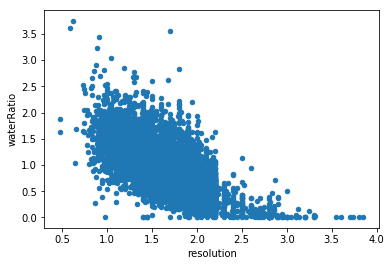

In [32]:
data = summary.toPandas()
data.plot(x='resolution', y='waterRatio', kind='scatter');

In [11]:
spark.stop()